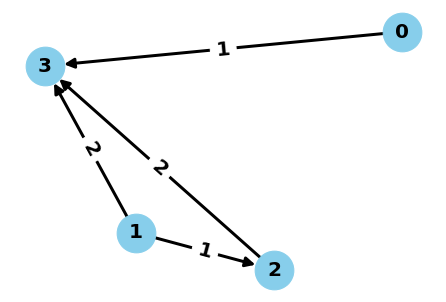

In [129]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement, combinations
from pyvis.network import Network

def plot_dag(adjaceny_matrix):

    G = nx.DiGraph(adjaceny_matrix)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    pos=nx.spring_layout(G)

    fs = 20
    nx.draw(G, pos = pos, node_size=1500, node_color="skyblue", edge_color="black", width=3, font_size=fs, font_weight='bold', arrowsize=20, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos = pos, edge_labels=edge_labels, font_size=fs, font_weight='bold')

    # net = Network(notebook=True,  cdn_resources='in_line')
    # net.from_nx(G)
    # net.show("dag.html")

    # draw edge labels

    plt.show()

def random_dag(n = 5, strength = 2, roots = 1):
    adjaceny_matrix = np.zeros((n, n))

    for i in range(n):
        hadnone = True
        for j in range(i+1, n):
            edge = np.random.randint(0, strength)
            
            if j < roots and i < roots:
                edge = 0

            if (j == n-1) and hadnone:
                edge = np.random.randint(1, strength)
            
            adjaceny_matrix[i, j] = edge
            
            if edge > 0:
                hadnone = False
        
    # make sure each node has at least one parent
    for i in range(roots,n):
        if np.sum(adjaceny_matrix[:, i]) == 0:
            j = np.random.randint(0, n)
            for _ in range(n):
                if j == i or adjaceny_matrix[i, j] == 1:
                    j = (j + 1) % n
            adjaceny_matrix[j, i] = 1
    
    for i in range(roots):
        adjaceny_matrix[:, i] = 0

    return adjaceny_matrix.astype(int)


def adj2edges(adj):
    edges = []
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if abs(adj[i, j]) > 0:
                edges.append((i, j))
    return edges


def var_node(node, dag):
    val = 0
    for i in range(0, dag.size):
        allpaths = dag.all_paths_between(i, node)
    
        for path1, path2 in product(allpaths, allpaths):
            if len(path1) == 0 or len(path2) == 0:
                continue

            p1 = np.prod([dag.adjaceny_matrix[edge[0], edge[1]] for edge in path1])  
            p2 = np.prod([dag.adjaceny_matrix[edge[0], edge[1]] for edge in path2])
            p_total = p1 * p2 * dag.biass[i]             

            val += p_total

    val += dag.biass[node]

    return val

# find all paths between two nodes in a directed acyclic graph

def find_all_paths(allpaths, edges, src, dest, path = []):
    if (src == dest):
        allpaths.append(np.array(path).copy())
    else:
        for adjnode in filter(lambda x: x[0] == src, edges):
            path.append(adjnode)
            find_all_paths(allpaths, edges, adjnode[1], dest, path)
            path.pop()


def simulate(dag, N = 100):
    adj = dag.adjaceny_matrix.copy()
    values = np.zeros((dag.size, N))
    visited = []

    while True:
        # find nodes without parents
        wh =  np.where(np.sum(adj, axis = 0) == 0)[0]
        # print("wh",np.where(np.sum(adj, axis = 0) == 0)[0])
        roots = list(filter(lambda x: x not in visited, wh))
        if len(roots) == 0:
            break
        for root in roots:
            visited.append(root)
            # add bias
            values[root] += np.random.normal(0, dag.biass[root], N)

            # propagate values
            for node, weigth in enumerate(adj[root, :]):
                # if there is a connection
                if abs(weigth) > 0:
                    values[node] += values[root] * weigth
                
            # remove connection
            adj[root, :] = 0

    return values

class DAG():
    def __init__(self, n = 5, strength = 2, roots = 1):
        self.adjaceny_matrix = random_dag(n = n, strength = strength, roots = roots)

        self.size = n

        self.biass = np.ones(n)
        # self.biass[0] = 1


    def plot(self):
        plot_dag(self.adjaceny_matrix)

    def all_paths_between(self, a, b):
        edges = adj2edges(self.adjaceny_matrix)
        allpaths = []
        find_all_paths(allpaths, edges, a, b)
        return allpaths
    
    
    def var_node(self, node):
        return var_node(node, self)

    def simulate(self, N = 100):
        return simulate(self, N = N)

dag = DAG(n = 4, strength = 3, roots = 2)
dag.plot()

In [122]:
dag.adjaceny_matrix

array([[0, 2, 2, 1, 0],
       [0, 0, 1, 2, 1],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0]])

In [130]:
sim = dag.simulate(1000000).var(axis = 1)
for i in range(dag.size):
    print("analytical", i, ":", round(sim[i]), "| simulated", ":", round(dag.var_node(i)))
    

analytical 0 : 1 | simulated : 1
analytical 1 : 1 | simulated : 1
analytical 2 : 2 | simulated : 2
analytical 3 : 22 | simulated : 22


$V_a = \sum^{nodes}_i\sum_{j,k}\prod^{path_{j}}_j\prod^{path_{ia}}_k W_j W_kV_i + V_a$

In [60]:
from itertools import combinations_with_replacement, combinations, product

for i in combinations_with_replacement(range(dag.size), 2):
    print(i)

print()
for i in product(range(dag.size), range(dag.size)):
    print(i)

(0, 0)
(0, 1)
(0, 2)
(1, 1)
(1, 2)
(2, 2)

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [283]:
adj = dag.adjaceny_matrix.copy()

N = 10






adj
 [[0 1 1]
 [0 0 1]
 [0 0 0]]
root 0
here!
adj
 [[0 0 0]
 [0 0 1]
 [0 0 0]]
root 1
here!
adj
 [[0 0 0]
 [0 0 0]
 [0 0 0]]
root 2
here!
adj
 [[0 0 0]
 [0 0 0]
 [0 0 0]]


In [286]:
values.var(axis = 1)

array([0.81126094, 0.8034279 , 4.22545177])

In [245]:
for i in range(dag.size):
    print("variance for node", i, ":",dag.var_node(i))

[array([], dtype=float64)]
[]
[]
variance for node 0 : 1.0
[array([[0, 1]])]
prod 1.0 for [[0 1]] [[0 1]]
[array([], dtype=float64)]
[]
variance for node 1 : 2.0
[array([[0, 1],
       [1, 2]]), array([[0, 2]])]
prod 1.0 for [[0 1]
 [1 2]] [[0 1]
 [1 2]]
prod 1.0 for [[0 1]
 [1 2]] [[0 2]]
prod 1.0 for [[0 2]] [[0 2]]
[array([[1, 2]])]
prod 1.0 for [[1 2]] [[1 2]]
[array([], dtype=float64)]
variance for node 2 : 5.0


In [77]:
def naive(dag):
    sums = np.zeros(dag.shape[0])
    sums[0] = 1

    for i in range(dag.shape[0]):
        unit_vector = np.zeros(dag.shape[0])
        unit_vector[i] = 1

        print(i)
        print(unit_vector @ dag)

        for vec, j in enumerate(unit_vector @ dag):
            sums[vec] += sums[i]*j
            # print(j)

    return sums

# print(naive(dag))
# print(getnum(dag))

In [100]:
# If ( src == dest ) then
# 2.      A path has been found. Push the path in the list of all_the_paths ( list of list ).
# 3.  Else
# 4.     For every adjacent node adj_node that is adjacent to src do
# 5.        Push adj_node in the path.
# 6.        DFS ( adj_node, dest, g )
# 7.        Pop adj_node from the path. This is essentially a backtracking mechanism to find a different path from the source ( src ) node.

# from adjacency matrix to list of edges



find_all_paths(adj2edges(dag), 0, 4)

print(allpaths)

[array([[0, 1],
       [1, 3],
       [3, 4]]), array([[0, 2],
       [2, 3],
       [3, 4]]), array([[0, 2],
       [2, 4]]), array([[0, 4]])]


[array([[0, 1],
        [1, 3],
        [3, 4]]),
 array([[0, 2],
        [2, 3],
        [3, 4]]),
 array([[0, 2],
        [2, 4]]),
 array([[0, 4]])]

In [88]:
adj2edges(dag)

[(0, 1), (0, 2), (0, 4), (1, 3), (2, 3), (2, 4), (3, 4)]

In [37]:
roads = getnum(dag)

biass = np.ones(dag.shape[0]) * 0.5

for i in range(dag.shape[0]):
    

In [ ]:
[1, 1, 1, 4, 9]

In [36]:
getnum(dag)

array([ 1,  1,  1,  4, 36], dtype=int32)

In [19]:
# take the adjancency matrix to the power of 2 to get the number of paths of length 2
roads = np.array([1, 1,1,1])

news = []
for i in range(len(roads)):
    new = roads * np.linalg.matrix_power(dag, i+1).T @ roads
    news.append(np.linalg.matrix_power(dag, i+1).T @ np.array([1,1,1,1]))
    roads[(roads > 0) * (new > 0)] += new[(roads > 0) * (new > 0)]

print(roads)
print(news)

[ 1  2  3 10]
[array([0, 1, 1, 3]), array([0, 0, 1, 2]), array([0, 0, 0, 1]), array([0, 0, 0, 0])]


In [25]:
def getnum(dag):
    plusone = np.zeros(dag.shape[0])
    plusone[0] = 1

    allones = np.ones(dag.shape[0])


    return dag.T @ allones + plusone, 